<a href="https://colab.research.google.com/github/NichaRoj/cubems-data-pipeline/blob/master/colab/explore_bigquery_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

time: 1.25 ms


In [15]:
# load extension to measure execution time
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=2b9ebae20cebef8028d929e13b5996bad5331f9f506918432d77c8881f326aa9
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Example: Using Colab Jupyter Notebook to explore data stored in BigQuery

First, you must authenticate to have access to BigQuery data.

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


Next, you can simply create a standard SQL query and run against BigQuery. For example, the following command run the SQL command against specified BigQuery table and put the result in Pandas dataframe called `df_imported`.

In [0]:
%%bigquery --project cubems-data-pipeline df_imported
SELECT 
  path, building, floor, zone, area, sub_area, sensor, pointid, datetime, date, time, value, last_created
FROM `cubems-data-pipeline.raw_chamchuri5.imported_data`

In [16]:
df_imported.dtypes

path                         object
building                     object
floor                        object
zone                         object
area                         object
sub_area                     object
sensor                       object
pointid                      object
datetime             datetime64[ns]
date                         object
time                         object
value                        object
last_created    datetime64[ns, UTC]
dtype: object

time: 5.4 ms


Then you can explore the data anyway you want!

The above command pulled data from `imported_data` in `raw_chamchuri5` dataset.
The table stores all data from all sensors up until yesterday.

Path represents where the sensor is in the format of `building/floor/zone/area/sub_area/sensor` and `pointid` shows the ID of all sensors represented by the path. If there are multiple sensors, the numbers are joined with ` | `

The value shows the value from sensor, so it should be changed to `float64` first.

Let's plot the graph of sensors with path `chamchuri5/fl2/z2/elevator_hall/shaft_room/aircon`

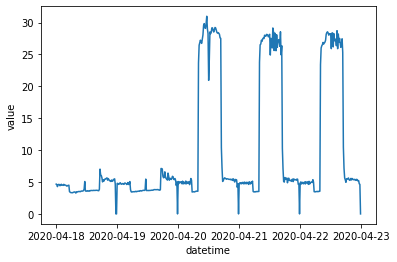

time: 329 ms


In [17]:
# Change dtypes of 'value' to float64
df_imported = df_imported.astype({'value': 'float64'})

# Get values of sensors with path "chamchuri5/fl2/z2/elevator_hall/shaft_room/aircon"
df_fl2z2_aircon = df_imported[df_imported['path'] == 'chamchuri5/fl2/z2/elevator_hall/shaft_room/aircon']

# Plot the graph
sns.lineplot(x='datetime', y='value', data=df_fl2z2_aircon)

Since April 18 and 19 fell was a weekend, the graph seemed reasonable. 

However, there were dips around the end/beginning of each day. This is because the API updates every 15 minute, but only upto just before current data i.e. calling the API at 12.32 will get data only upto 12.15. This means that for data at 23.45, the API must be called later than at midnight, but the API would send response for the next day instead.

Let's try to replace those values.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


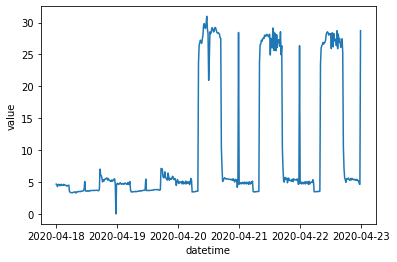

time: 247 ms


In [18]:
# Replace 0
df_fl2z2_aircon_fixed = df_fl2z2_aircon
df_fl2z2_aircon_fixed.loc[:, 'value'] = df_fl2z2_aircon_fixed['value'].replace(to_replace=0, method='ffill', limit=1)

# Plot the graph
sns.lineplot(x='datetime', y='value', data=df_fl2z2_aircon_fixed)

It is not the prettiest but it will work for now.

Since table `imported_data` contains data upto the previous day, we need to import data from `temp_data` for the current day.

The reason that the tables are split because queries are constantly executed in `temp_data` thus keeping a large amount of data in `temp_data` will accumulate the cost.

In [0]:
%%bigquery --project cubems-data-pipeline df_temp
SELECT 
  path, building, floor, zone, area, sub_area, sensor, pointid, datetime, date, time, value, last_created
FROM `cubems-data-pipeline.raw_chamchuri5.temp_data`

In [4]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   path          20544 non-null  object             
 1   building      20544 non-null  object             
 2   floor         20544 non-null  object             
 3   zone          20544 non-null  object             
 4   area          20544 non-null  object             
 5   sub_area      20544 non-null  object             
 6   sensor        20544 non-null  object             
 7   pointid       20544 non-null  object             
 8   datetime      20544 non-null  datetime64[ns]     
 9   date          20544 non-null  object             
 10  time          20544 non-null  object             
 11  value         20544 non-null  object             
 12  last_created  20544 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(11)
memo

Since there are 107 sensors and number of rows pulled should be 96 per sensors, there should be 10,272 rows. If there are 20,544 rows, that means data is pulled but not updated yet, so we must delete the obsolete rows first.

In [8]:
# See values of last_created to see when rows are created.
last_created = df_temp['last_created'].unique()
last_created

<DatetimeArray>
['2020-04-23 13:57:02+00:00', '2020-04-23 14:12:02+00:00']
Length: 2, dtype: datetime64[ns, UTC]

In [10]:
df_temp = df_temp.drop(df_temp[df_temp['last_created']  == last_created[0]].index)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10272 entries, 10272 to 20543
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   path          10272 non-null  object             
 1   building      10272 non-null  object             
 2   floor         10272 non-null  object             
 3   zone          10272 non-null  object             
 4   area          10272 non-null  object             
 5   sub_area      10272 non-null  object             
 6   sensor        10272 non-null  object             
 7   pointid       10272 non-null  object             
 8   datetime      10272 non-null  datetime64[ns]     
 9   date          10272 non-null  object             
 10  time          10272 non-null  object             
 11  value         10272 non-null  object             
 12  last_created  10272 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(11)


Now they can be combined.

In [19]:
df_chamchuri5 = pd.concat([df_temp, df_imported], ignore_index=True)
df_chamchuri5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59900 entries, 0 to 59899
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   path          59900 non-null  object             
 1   building      59900 non-null  object             
 2   floor         59900 non-null  object             
 3   zone          59900 non-null  object             
 4   area          59900 non-null  object             
 5   sub_area      59900 non-null  object             
 6   sensor        59900 non-null  object             
 7   pointid       59900 non-null  object             
 8   datetime      59900 non-null  datetime64[ns]     
 9   date          59900 non-null  object             
 10  time          59900 non-null  object             
 11  value         59900 non-null  object             
 12  last_created  59900 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(11)
memo

Now you can explore data all you want!

Let's try plotting a graph for all aircon sensors.

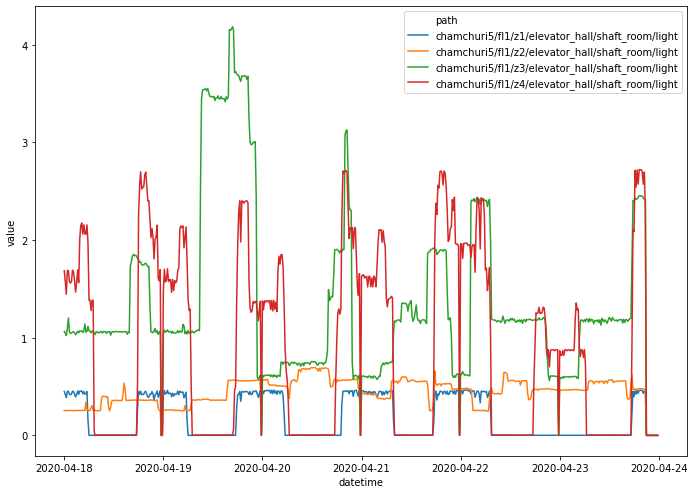

time: 627 ms


In [37]:
# Change dtypes of 'value' to float64
df_chamchuri5 = df_chamchuri5.astype({'value': 'float64'})

# Get data from aircon sensors
df_chamchuri5_fl1light = df_chamchuri5[(df_chamchuri5['sensor'] == 'light') & (df_chamchuri5['zone'] != 'z0') & (df_chamchuri5['floor'] == 'fl1')]

# Plot the graph
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, x='datetime', y='value', data=df_chamchuri5_fl1light, hue='path')

It should be noted that the combined data hasn't have data with 0 dropped yet. But now data can be used for data visualization or exploratory analysis now.